# **Deteksi Outlier dengan K-Nearest Neighbors (KNN) dalam Data Understanding**

## 1. Mengapa KNN Bisa Digunakan untuk Deteksi Outlier?  
K-Nearest Neighbors (KNN) bisa digunakan untuk deteksi outlier karena prinsip dasarnya adalah mengukur kedekatan antara titik data dalam suatu ruang fitur. Outlier adalah titik data yang berada jauh dari mayoritas titik lain, sehingga dalam metode KNN, outlier akan memiliki tetangga yang lebih sedikit atau lebih jauh dibandingkan titik normal.

## 2. Langkah-langkah Deteksi Outlier dengan KNN
1. Menentukan Jumlah Tetangga (k)
* Nilai k (n_neighbors) menentukan seberapa banyak tetangga yang dipertimbangkan untuk menentukan apakah suatu titik adalah outlier.
* Nilai k yang terlalu kecil bisa membuat metode terlalu sensitif terhadap noise.
* Nilai k yang terlalu besar bisa membuat outlier sulit terdeteksi karena ikut dalam kelompok besar.
* Biasanya, k ditentukan dengan eksperimen atau menggunakan aturan √(jumlah data) sebagai titik awal.
2. Menerapkan Local Outlier Factor (LOF) dengan KNN
* Gunakan model Local Outlier Factor (LOF) dari sklearn.neighbors.LocalOutlierFactor.
* LOF menghitung kepadatan lokal dari setiap titik data dan membandingkannya dengan kepadatan tetangganya.
* Data dengan kepadatan yang jauh lebih rendah dibandingkan tetangga-tetangganya dianggap sebagai outlier.

## Kesimpulan
Metode KNN untuk deteksi outlier menggunakan konsep kedekatan antar titik untuk mengidentifikasi data yang berbeda secara signifikan dari yang lain. Dengan menggunakan Local Outlier Factor (LOF), kita dapat menemukan titik-titik yang memiliki kepadatan lebih rendah dibandingkan tetangganya.



In [4]:
%pip install pymysql
%pip install psycopg2

Code diatas untuk menginstal pustaka Python PyMySQL dan Psycopg2, yang digunakan untuk menghubungkan Python dengan database:

pymysql → Untuk koneksi ke database MySQL
psycopg2 → Untuk koneksi ke database PostgreSQL

 id           class  petal_length  petal_width  sepal_length  sepal_width  knn_distance  outlier_knn
  1     Iris-setosa           1.4          0.2           5.1          3.5      0.141421        False
  2     Iris-setosa          14.0          2.0          40.9         30.0     23.358296         True
  3     Iris-setosa           1.3          0.2           4.7          3.2      0.264575        False
  4     Iris-setosa           1.5          0.2           4.6          3.1      0.244949        False
  5     Iris-setosa           1.4          0.2           5.0          3.6      0.223607        False
  6     Iris-setosa          17.0          4.0          54.0         39.0     16.552945         True
  7     Iris-setosa           1.4          0.3           4.6          3.4      0.316228        False
  8     Iris-setosa           1.5          0.2           5.0          3.4      0.200000        False
  9     Iris-setosa           1.4          0.2           4.4          2.9      0.360555    

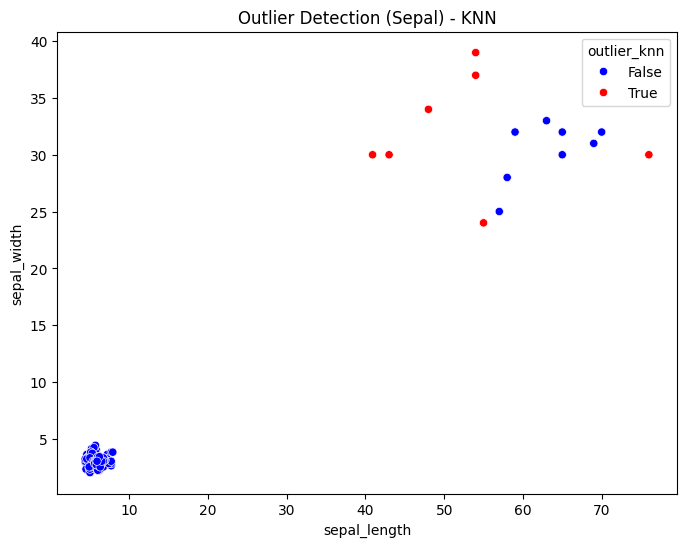

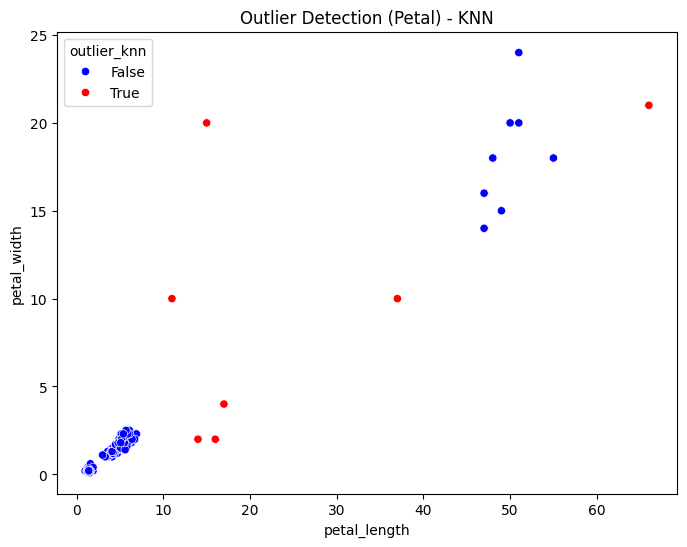

In [5]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def get_pg_data():
    conn = psycopg2.connect(
        host="pg-2784e994-malikaauliaaa2-1544.h.aivencloud.com",
        user="avnadmin",
        password="AVNS_7OwV6So2k6qKTb1yXO0",
        database="defaultdb",
        port=26315
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM tabel2")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-a971b40-malikaauliaaa2-1544.h.aivencloud.com",
        user="avnadmin",
        password="AVNS_xWwDDfEtRsiv7WGcUgO",
        database="irish",
        port=26315
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM tabel1")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merged[feature_columns].values

# KNN Outlier Detection
def knn_outlier_detection(data, k=5):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    avg_distances = distances[:, -1]  # Ambil jarak k-terjauh sebagai skor
    return avg_distances

# Hitung K-NN distance
df_merged["knn_distance"] = knn_outlier_detection(data_values, k=5)

# Tentukan threshold sebagai nilai rata-rata + 2 standar deviasi
threshold = df_merged["knn_distance"].mean() + 2 * df_merged["knn_distance"].std()
df_merged["outlier_knn"] = df_merged["knn_distance"] > threshold

# Cetak hasil
df_result = df_merged[["id", "class", "petal_length", "petal_width", "sepal_length", "sepal_width", "knn_distance", "outlier_knn"]]
print(df_result.to_string(index=False))
num_outliers = df_merged["outlier_knn"].sum()
print(f"\nJumlah outlier: {num_outliers}")

# Cetak data outlier
outliers = df_merged[df_merged["outlier_knn"]]
print("\nData Outlier:")
print(outliers.to_string(index=False))

# Visualisasi outlier berdasarkan K-NN
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_merged["sepal_length"], y=df_merged["sepal_width"],
    hue=df_merged["outlier_knn"], palette={False: "blue", True: "red"}
)
plt.title("Outlier Detection (Sepal) - KNN")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_merged["petal_length"], y=df_merged["petal_width"],
    hue=df_merged["outlier_knn"], palette={False: "blue", True: "red"}
)
plt.title("Outlier Detection (Petal) - KNN")
plt.show()

Kode di atas menggunakan metode K-Nearest Neighbors (KNN) untuk mendeteksi outlier dalam dataset yang diperoleh dari dua database yang berbeda, yaitu PostgreSQL dan MySQL. Pertama, kode ini melakukan koneksi ke kedua database menggunakan pustaka psycopg2 untuk PostgreSQL dan pymysql untuk MySQL. Setelah berhasil terhubung, data diambil dari masing-masing tabel (iris_postgresql dan irismysql) dan dikonversi menjadi DataFrame Pandas.

Selanjutnya, kedua dataset tersebut digabungkan berdasarkan kolom id dan class menggunakan metode pd.merge(), sehingga hanya data yang memiliki kecocokan dalam kedua database yang disertakan dalam analisis. Dari hasil penggabungan ini, hanya fitur numerik yang dipilih, yaitu petal_length, petal_width, sepal_length, dan sepal_width, yang akan digunakan untuk deteksi outlier.

Metode KNN Outlier Detection diterapkan dengan menggunakan kelas NearestNeighbors dari scikit-learn. Model ini menghitung jarak k-tetangga terdekat untuk setiap titik dalam dataset. Nilai k ditentukan sebagai 5, yang berarti bahwa setiap titik akan dibandingkan dengan 5 tetangga terdekatnya. Kemudian, nilai jarak rata-rata terhadap tetangga ke-k digunakan sebagai skor anomali (semakin besar nilainya, semakin jauh titik tersebut dari kelompoknya).

Untuk mengidentifikasi outlier, ditentukan threshold berdasarkan rata-rata nilai jarak KNN ditambah 2 kali standar deviasi. Jika jarak suatu titik lebih besar dari threshold ini, maka titik tersebut dianggap sebagai outlier dan diberi label True pada kolom outlier_knn. Hasil analisis ditampilkan dengan menampilkan DataFrame yang mencantumkan nilai fitur dan status outlier setiap titik, serta jumlah total outlier dalam dataset.

Terakhir, hasil deteksi outlier divisualisasikan menggunakan Seaborn dan Matplotlib. Scatter plot dibuat untuk menunjukkan penyebaran data berdasarkan fitur sepal dan petal, dengan outlier ditandai dalam warna merah dan data normal dalam warna biru. Ini memungkinkan pengguna untuk dengan mudah mengidentifikasi titik-titik anomali dalam dataset berdasarkan metode KNN.









In [6]:
# Filter data non-outlier (tanpa outlier)
df_non_outliers = df_merged[df_merged["outlier_knn"] == False]

# Menampilkan jumlah data non-outlier
jumlah_data_non_outliers = len(df_non_outliers)

# Tampilkan jumlah data non-outlier
print(f"Jumlah dataset yang sudah bersih (tanpa outlier): {jumlah_data_non_outliers}")

# Tampilkan data non-outlier
print("\nData yang sudah bersih (tanpa outlier):")
print(df_non_outliers.to_string(index=False))


Jumlah dataset yang sudah bersih (tanpa outlier): 143

Data yang sudah bersih (tanpa outlier):
 id           class  petal_length  petal_width  sepal_length  sepal_width  knn_distance  outlier_knn
  1     Iris-setosa           1.4          0.2           5.1          3.5      0.141421        False
  3     Iris-setosa           1.3          0.2           4.7          3.2      0.264575        False
  4     Iris-setosa           1.5          0.2           4.6          3.1      0.244949        False
  5     Iris-setosa           1.4          0.2           5.0          3.6      0.223607        False
  7     Iris-setosa           1.4          0.3           4.6          3.4      0.316228        False
  8     Iris-setosa           1.5          0.2           5.0          3.4      0.200000        False
  9     Iris-setosa           1.4          0.2           4.4          2.9      0.360555        False
 10     Iris-setosa           1.5          0.1           4.9          3.1      0.173205        Fa

In [7]:
# Filter data non-outlier (tanpa outlier)
df_non_outliers = df_merged[df_merged["outlier_knn"] == False]

# Menampilkan jumlah data non-outlier
jumlah_data_non_outliers = len(df_non_outliers)

# Tampilkan jumlah data non-outlier
print(f"Jumlah dataset yang sudah bersih (tanpa outlier): {jumlah_data_non_outliers}")

# Menampilkan data yang sudah bersih (tanpa outlier)
print("\nData yang sudah bersih (tanpa outlier):")
print(df_non_outliers.to_string(index=False))

# Data sudah dimasukkan ke DataFrame df_non_outliers


Jumlah dataset yang sudah bersih (tanpa outlier): 143

Data yang sudah bersih (tanpa outlier):
 id           class  petal_length  petal_width  sepal_length  sepal_width  knn_distance  outlier_knn
  1     Iris-setosa           1.4          0.2           5.1          3.5      0.141421        False
  3     Iris-setosa           1.3          0.2           4.7          3.2      0.264575        False
  4     Iris-setosa           1.5          0.2           4.6          3.1      0.244949        False
  5     Iris-setosa           1.4          0.2           5.0          3.6      0.223607        False
  7     Iris-setosa           1.4          0.3           4.6          3.4      0.316228        False
  8     Iris-setosa           1.5          0.2           5.0          3.4      0.200000        False
  9     Iris-setosa           1.4          0.2           4.4          2.9      0.360555        False
 10     Iris-setosa           1.5          0.1           4.9          3.1      0.173205        Fa

In [8]:
# Hapus baris terakhir jika jumlah data lebih dari 150
if len(df_non_outliers) > 150:
    df_non_outliers = df_non_outliers.drop(df_non_outliers.index[-1])

# Pastikan jumlah data sudah 150
print(f"Jumlah dataset setelah diubah: {len(df_non_outliers)}")

# Tampilkan data yang sudah difilter dan diperkecil jumlahnya
print("\nData setelah diubah:")
print(df_non_outliers.to_string(index=False))


Jumlah dataset setelah diubah: 143

Data setelah diubah:
 id           class  petal_length  petal_width  sepal_length  sepal_width  knn_distance  outlier_knn
  1     Iris-setosa           1.4          0.2           5.1          3.5      0.141421        False
  3     Iris-setosa           1.3          0.2           4.7          3.2      0.264575        False
  4     Iris-setosa           1.5          0.2           4.6          3.1      0.244949        False
  5     Iris-setosa           1.4          0.2           5.0          3.6      0.223607        False
  7     Iris-setosa           1.4          0.3           4.6          3.4      0.316228        False
  8     Iris-setosa           1.5          0.2           5.0          3.4      0.200000        False
  9     Iris-setosa           1.4          0.2           4.4          2.9      0.360555        False
 10     Iris-setosa           1.5          0.1           4.9          3.1      0.173205        False
 13     Iris-setosa           1.4 

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Pastikan data sudah difilter tanpa outlier (LOF)
df_non_outliers = df_merged[df_merged["outlier_knn"] == False]

# Jika jumlah data lebih dari 150, kurangi jadi 150
if len(df_non_outliers) > 150:
    df_non_outliers = df_non_outliers.drop(df_non_outliers.index[-1])

# Menampilkan jumlah data non-outlier setelah pengurangan
print(f"Jumlah dataset yang sudah difilter (tanpa outlier) setelah pengurangan: {len(df_non_outliers)}")

# Siapkan fitur dan label untuk klasifikasi
X = df_non_outliers[["petal_length", "petal_width", "sepal_length", "sepal_width"]]  # Fitur
y = df_non_outliers["class"]  # Label

# Bagi data menjadi training dan testing set (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)  # n_neighbors bisa disesuaikan

# Latih model KNN
knn.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = knn.predict(X_test)

# Evaluasi model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Jika Anda ingin menyimpan model menggunakan pickle
import pickle
with open("knn_model.pkl", "wb") as f:
    pickle.dump(knn, f)

Jumlah dataset yang sudah difilter (tanpa outlier) setelah pengurangan: 143
Accuracy: 0.896551724137931

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         8
Iris-versicolor       1.00      0.73      0.84        11
 Iris-virginica       0.77      1.00      0.87        10

       accuracy                           0.90        29
      macro avg       0.92      0.91      0.90        29
   weighted avg       0.92      0.90      0.90        29



In [10]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Filter data non-outlier (tanpa outlier)
df_non_outliers = df_merged[df_merged["outlier_knn"] == False]

# Pastikan jumlah data sudah diinginkan (150)
if len(df_non_outliers) > 150:
    df_non_outliers = df_non_outliers.drop(df_non_outliers.index[-1])

# Tampilkan jumlah data non-outlier setelah pengurangan
print(f"Jumlah dataset yang sudah difilter (tanpa outlier): {len(df_non_outliers)}")

# Siapkan fitur dan label untuk klasifikasi
X = df_non_outliers[["petal_length", "petal_width", "sepal_length", "sepal_width"]]  # 4 fitur
y = df_non_outliers["class"]  # Label

# Bagi data menjadi training dan testing set (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)  # n_neighbors bisa disesuaikan

# Latih model KNN
knn.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = knn.predict(X_test)

# Evaluasi model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Jika Anda ingin menyimpan model menggunakan pickle
import pickle
with open("knn_model.pkl", "wb") as f:
    pickle.dump(knn, f)


Jumlah dataset yang sudah difilter (tanpa outlier): 143
Accuracy: 0.896551724137931

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         8
Iris-versicolor       1.00      0.73      0.84        11
 Iris-virginica       0.77      1.00      0.87        10

       accuracy                           0.90        29
      macro avg       0.92      0.91      0.90        29
   weighted avg       0.92      0.90      0.90        29



In [11]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Filter data non-outlier (tanpa outlier)
df_non_outliers = df_merged[df_merged["outlier_knn"] == False]

# Pastikan jumlah data sudah diinginkan (150)
if len(df_non_outliers) > 150:
    df_non_outliers = df_non_outliers.drop(df_non_outliers.index[-1])

# Tampilkan jumlah data non-outlier setelah pengurangan
print(f"Jumlah dataset yang sudah difilter (tanpa outlier) setelah pengurangan: {len(df_non_outliers)}")

# Siapkan fitur dan label untuk klasifikasi
X = df_non_outliers[["petal_length", "petal_width", "sepal_length", "sepal_width"]]  # 4 fitur
y = df_non_outliers["class"]  # Label

# Bagi data menjadi training dan testing set (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tampilkan jumlah data training dan testing
print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")

# Inisialisasi KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)  # n_neighbors bisa disesuaikan

# Latih model KNN
knn.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = knn.predict(X_test)

# Evaluasi model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Jika Anda ingin menyimpan model menggunakan pickle
import pickle
with open("knn_model.pkl", "wb") as f:
    pickle.dump(knn, f)


Jumlah dataset yang sudah difilter (tanpa outlier) setelah pengurangan: 143
Jumlah data training: 114
Jumlah data testing: 29
Accuracy: 0.896551724137931

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         8
Iris-versicolor       1.00      0.73      0.84        11
 Iris-virginica       0.77      1.00      0.87        10

       accuracy                           0.90        29
      macro avg       0.92      0.91      0.90        29
   weighted avg       0.92      0.90      0.90        29



In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Filter data non-outlier (tanpa outlier)
df_non_outliers = df_merged[df_merged["outlier_knn"] == False]

# Pastikan jumlah data sudah diinginkan (150)
if len(df_non_outliers) > 150:
    df_non_outliers = df_non_outliers.drop(df_non_outliers.index[-1])

# Tampilkan jumlah data non-outlier setelah pengurangan
print(f"Jumlah dataset yang sudah difilter (tanpa outlier) setelah pengurangan: {len(df_non_outliers)}")

# Siapkan fitur dan label untuk klasifikasi
X = df_non_outliers[["petal_length", "petal_width", "sepal_length", "sepal_width"]]  # 4 fitur
y = df_non_outliers["class"]  # Label

# Split dataset menjadi dua bagian: training + validation dan testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tampilkan data testing
print(f"\nData Testing (20%):")
print(X_test.head())  # Menampilkan 5 data teratas dari data testing

# Split training + validation menjadi training dan validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

# Tampilkan data training dan validation
print(f"\nData Training (80%):")
print(X_train.head())  # Menampilkan 5 data teratas dari data training

print(f"\nData Validation (10%):")
print(X_val.head())  # Menampilkan 5 data teratas dari data validation

# Inisialisasi KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)  # n_neighbors bisa disesuaikan

# Latih model KNN dengan training data
knn.fit(X_train, y_train)

# Evaluasi model pada data validation
y_val_pred = knn.predict(X_val)

# Tampilkan akurasi pada data validation
print(f"\nAkurasi pada data validation: {accuracy_score(y_val, y_val_pred)}")

# Prediksi pada data uji (testing)
y_test_pred = knn.predict(X_test)

# Evaluasi model pada data testing
print("\nAccuracy on Test Data:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_test_pred))

# Jika Anda ingin menyimpan model menggunakan pickle
import pickle
with open("knn_model.pkl", "wb") as f:
    pickle.dump(knn, f)


Jumlah dataset yang sudah difilter (tanpa outlier) setelah pengurangan: 143

Data Testing (20%):
     petal_length  petal_width  sepal_length  sepal_width
124           5.7          2.1           6.7          3.3
24            1.9          0.2           4.8          3.4
88            4.1          1.3           5.6          3.0
103           5.6          1.8           6.3          2.9
61            4.2          1.5           5.9          3.0

Data Training (80%):
     petal_length  petal_width  sepal_length  sepal_width
96            4.2          1.3           5.7          2.9
98            3.0          1.1           5.1          2.5
29            1.6          0.2           4.7          3.2
131           6.4          2.0           7.9          3.8
55            4.5          1.3           5.7          2.8

Data Validation (10%):
     petal_length  petal_width  sepal_length  sepal_width
97            4.3          1.3           6.2          2.9
21            1.5          0.4           5.1 